# Brake-Reuß Beam - DIC data

We consider digital image correlation measurements from a shaker ringdown test on a beam with a bolted lap joint [1,2]. Oscillations are initialized close to its slowest 2D spectral submanifold (SSM), which will be identified and used for model reduction.
The dataset contains the displacement field (206 points in 720 mm of beam length) of the bottom beam side measured via DIC and accelerations measured via accelerometers (ACC) in 2 locations. All data refers to a single experimental trial, acquired with different measurement devices (as described in [1]). The dataset also includes backbone curves results obtained using the Peak Finding and Fitting (PFF) method based on accelerometer signals. 
Here we construct a reduced-order model using DIC data and we validate it on the acceleration signals.


[1] W. Chen, D. Jana, A. Singh, M. Jin, M. Cenedese, G. Kosova, M. W. R. Brake, C. W. Schwingshackl, S. Nagarajaiah, K. Moore, and J. P. Noël. Measurement and identification of the nonlinear dynamics of a jointed structure using full-field data; Part I - Measurement of nonlinear dynamics. Mechanical Systems and Signal Processing, 166:108401, 2022. https://doi.org/10.1016/j.ymssp.2021.108401
[2] M. Jin, G. Kosova, M. Cenedese, W. Chen, D. Jana, A. Singh, M. W. R. Brake, C. W. Schwingshackl, S. Nagarajaiah, K. Moore, and J. P. Noël. Measurement and identification of the nonlinear dynamics of a jointed structure using full-field data; Part II - Nonlinear system identification. Mechanical Systems and Signal Processing, 166:108402, 2022. https://doi.org/10.1016/j.ymssp.2021.108402

This example follows https://github.com/mattiacenedese/SSMLearn/tree/main/examples/brakereussbeam

In [2]:
from scipy.io import loadmat
from ssmlearnpy import SSMLearn
import numpy as np


In [3]:
data = loadmat('data.mat')['data_BRB']

In [4]:

TimeDIC = data[0,0].item()[0]
DisplacementDIC = data[0,0].item()[1]
TimeACC = data[0,0].item()[2]
AccelerationACC = data[0,0].item()[3]
Xmesh = data[0,0].item()[4]
Units = data[0,0].item()[5]
LocationACC = data[0,0].item()[6]
PFFResultsACC = data[0,0].item()[7]

In [5]:
time_to_plot = np.logical_and(TimeDIC<3/80, TimeDIC>0) # range to plot in the original script

In [6]:
TT, XX = np.meshgrid(TimeDIC[time_to_plot], Xmesh)

#  Experimental Data

We will divide the data into a training set, for model fitting, and a test set, for validation. In this case the experimental data consists of a single trajectory, with different measruements. We train on DIC data and validate on acceleration data.

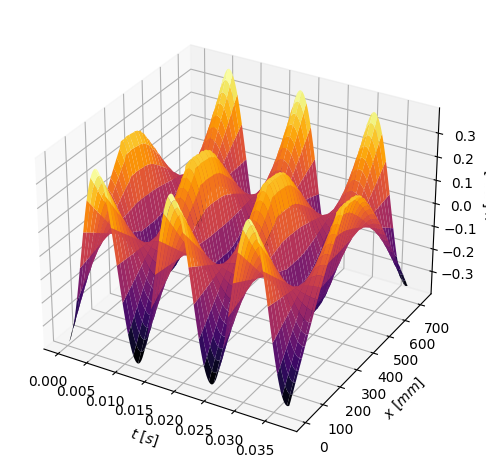

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(TT, XX, DisplacementDIC[:, time_to_plot[:,0]], cmap = 'inferno')
ax.set_xlabel('$t\ [s]$')
ax.set_ylabel('$x\ [mm]$')
ax.set_zlabel('$u\ [mm]$')

fig.set_tight_layout('tight')

# Delay embedding

To diversify the data, we augment displacements with four delayed measurements. We do this by explicitly calling the coordinates embedding function. 
We also specify the ```over_embedding``` parameter, which means the minimum dimension of the manifold will be 5 in this case.

In [10]:
from ssmlearnpy.geometry.coordinates_embedding import coordinates_embedding
t_y, y, opts_embedding = coordinates_embedding([TimeDIC.ravel()], [DisplacementDIC],
                                               imdim = 2, over_embedding = 5)

INFO   2023-04-20 15:26:26 coordinates_embedding The 1236 embedding coordinates consist of the 206 measured states and their 5 time-delayed measurements.


We can then initialize the SSMLearn object with the delayed coordinates. 

In [11]:
ssm = SSMLearn(
    t = t_y, 
    x = y, 
    derive_embdedding=False,
    ssm_dim=2, 
    dynamics_type = 'flow',
)

# Datadriven manifold fitting

The measured trajectories are assumed to lie close to a two-dimensional manifold that is tangent at the origin to the eigenspace corresponding to the slowest pair of eigenvalues. We now want to fit a polynomial of order  to the data points to approximate the manifold. Here we use a graph style parametrization, meaning that the manifold is parametrized using coordinates in an eigenspace $V_e$.

We determine the eigenspace using SVD, with the method ```ssm.get_reduced_coordinates()```

In [13]:
ssm.get_reduced_coordinates('linearchart')


In [14]:
from ssmlearnpy.utils.plots import Plot

plotter = Plot(
    label_observables = 'x',
    label_reduced_coordinates = 'eta'
)

fig = plotter.make_plot(ssm, data_name = 'reduced_coordinates', idx_coordinates=[1, 2])
fig.show()

Then we fit a quadratic manifold to the delay embedded coordinates. 

In [17]:
ssm.get_parametrization(poly_degree = 2 )


INFO   2023-04-20 15:30:40 ridge Transforming data
INFO   2023-04-20 15:30:40 ridge Skipping CV on ridge regression
INFO   2023-04-20 15:30:40 ridge Fitting regression model


We plot the manifold over the reduced coordinates, by calculating the position of the first degree of freedom. 

In [24]:
outdof = 0

In [21]:
eta1 = np.linspace(-10, 10, 100)
eta2 = np.linspace(-2, 2, 100)
E1, E2 = np.meshgrid(eta1, eta2)

points_in_reduced_space = np.vstack((E1.ravel(), E2.ravel())).T

In [22]:
Manifold_points = ssm.decoder.predict(points_in_reduced_space)

In [29]:
Manifold_points = np.squeeze(Manifold_points[:, outdof]).reshape(E1.shape)

<IPython.core.display.Javascript object>


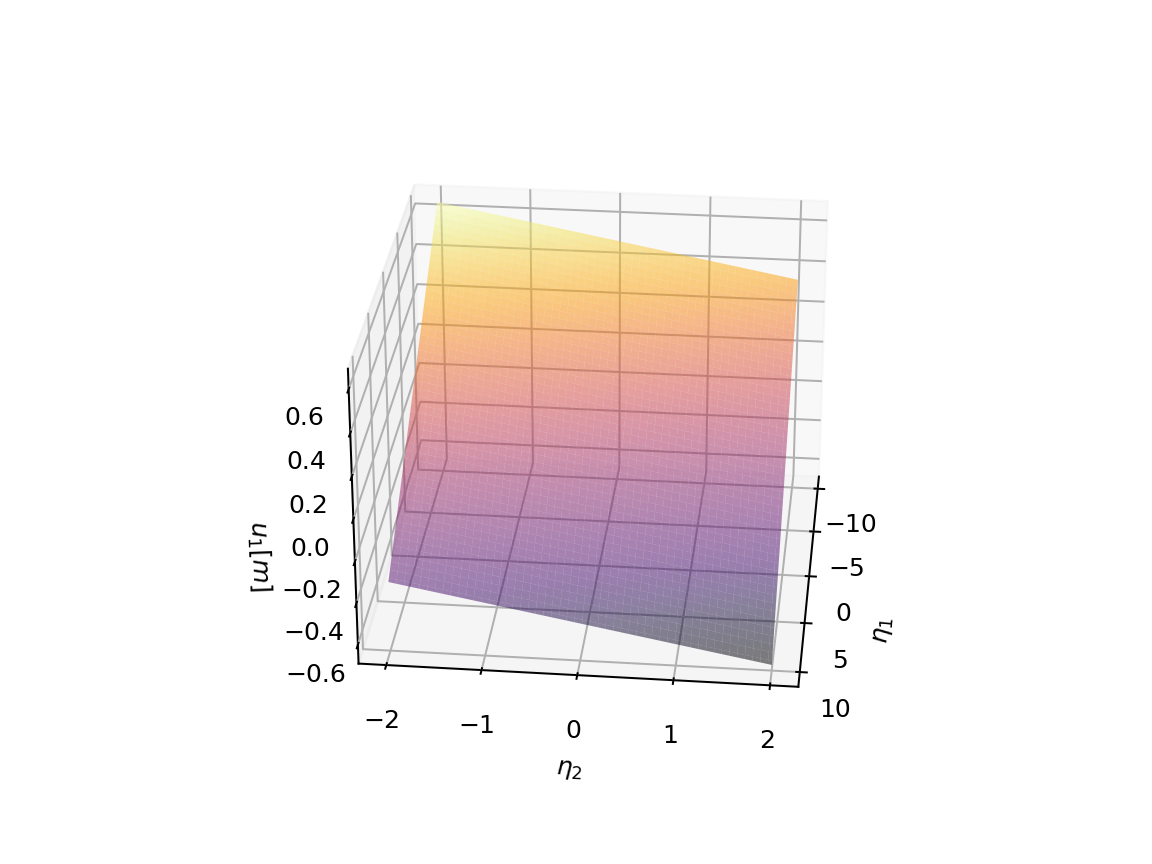

In [35]:
fig = plt.figure()
%matplotlib notebook
ax = fig.add_subplot(111, projection = '3d')

ax.plot_surface(E1, E2, Manifold_points, cmap = 'inferno', antialiased = True, alpha = 0.5)
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax.set_zlabel('$u_1[m]$')
fig.show()

# Reduced order model


We fit a model of polynomial degree 11 to the training data. 

In [48]:
ssm.get_reduced_dynamics(poly_degree = 12)

INFO   2023-04-20 15:42:00 ridge Transforming data
INFO   2023-04-20 15:42:00 ridge Skipping CV on ridge regression
INFO   2023-04-20 15:42:00 ridge Fitting regression model


Then we pose the minimization problem to find the normal form

In [49]:
from scipy.optimize import minimize, least_squares
import ssmlearnpy.reduced_dynamics.normalform as normalform

In [51]:
poly_order = 12
linearPart = ssm.reduced_dynamics.map_info['coefficients'][:,:2]
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(ssm.emb_data['time'], ssm.emb_data['reduced_coordinates'], linearPart, degree = poly_order)
initial_guess = np.random.rand((n_unknowns_dynamics+n_unknowns_transformation)*2)


With such a high order of the normal form, the computation takes a while. 

In [52]:
ndofs = 1
np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)


In [53]:
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, poly_order,d)#,  find_inverse=True, trajectories=ssm.emb_data['reduced_coordinates'])

In [54]:
import ssmlearnpy.utils.postprocessing as postprocessing

In [55]:
var, varbar, eqs = postprocessing.display_equation(dyn['coefficients'], dyn['exponents'], base_symbol='z', complex=True)



In [56]:
variables = [var[0], varbar[0]]

In [57]:
r, phi, req, phieq = postprocessing.convert_to_polar(variables, eqs)

In [58]:
postprocessing.disp('\\dot{r}_0=', req[0])
postprocessing.disp('\\dot{\\varphi}_0=', phieq[0])
